<a href="https://colab.research.google.com/github/rymuelle/10_0_X_alignment_residual_check/blob/master/simpleCFBMinimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
import pandas as pd
from google.colab import files, drive
import os
import math
import matplotlib.pyplot as plt

In [0]:
dtype = torch.float
device = torch.device("cpu")
device = torch.device("cuda:0")

Mount drive and get our game CSV:

In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
game_history=pd.read_csv('/content/drive/My Drive/Colab Notebooks/CFB_pytorch_toy_minimizer/game_history.csv')
game_history_2019=game_history[game_history.season.fillna(0).astype(int)==2019]
game_history_2019.head()

,team1,team2,team1Home,score1,score2,ordinal_date,season
98528,St Mary's NS,St Fran Xavier,-1,39,7.0,737288.0,2019.0
98529,Acadia,Mt Allison,-1,13,29.0,737288.0,2019.0
98530,Manitoba,Regina,-1,12,9.0,737292.0,2019.0
98531,Coffeyville CC,Iowa Western CC,-1,14,36.0,737293.0,2019.0
98532,Hutchinson CC,Ellsworth CC,-1,41,16.0,737293.0,2019.0


(array([206., 836., 819., 796., 867., 814., 586., 134.,  27.,  20.]),
 array([737288. , 737302.9, 737317.8, 737332.7, 737347.6, 737362.5,
        737377.4, 737392.3, 737407.2, 737422.1, 737437. ]),
 <a list of 10 Patch objects>)

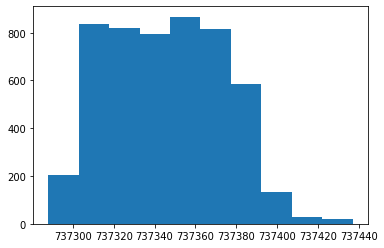

In [5]:
plt.hist(game_history_2019.ordinal_date, 10)

Now, build list and dict of teams. Dict converts between index and name, list stores team power

In [0]:
team_list=pd.concat([game_history_2019.team1,game_history_2019.team2]).unique()
team_list=np.append(team_list,'home_field')
team_dict={team:count for count,team in enumerate(team_list)}

We've added a cutoff here for some rough testing:

In [0]:
count=0
lengthX=len(team_list)
game_array=[]
spread_array=[]
game_array_test=[]
spread_array_test=[]
cutoff=1000000
for index, row in game_history_2019.iterrows():
  game=np.zeros(lengthX)
  game[team_dict[row.team1]]=1
  game[team_dict[row.team2]]=-1
  game[lengthX-1]=row.team1Home
  spread = row.score1-row.score2
  if not math.isnan(spread):
    if row.ordinal_date<cutoff: 
      game_array.append(game)
      spread_array.append(spread)
    else:
      game_array_test.append(game)
      spread_array_test.append(spread)
  else:
    print(spread)
  #if count > 1000: break
  count+=1

Our "network" is litterally one node. Team1 power - Team2 power + homefield advantage = predicted score.

Weights here will reflect team power and home field advantage.

In [132]:
team_power=torch.zeros(len(team_list),1, device=device, dtype=dtype, requires_grad=True)
x=torch.tensor(game_array, device=device, dtype=dtype)
y=torch.tensor(spread_array, device=device, dtype=dtype).unsqueeze(1)
print(x.shape)
print(team_power.shape)
print(y.shape)

torch.Size([5105, 928])
torch.Size([928, 1])
torch.Size([5105, 1])


Now, lets optimize team's power:

In [134]:
learning_rate = 1e-3
nGames=len(x)
optimizer = torch.optim.Adam([team_power], lr=learning_rate)
for t in range(100000):
  pred_spread=x.mm(team_power)
  loss=(pred_spread - y).pow(2).sum()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  loss=math.sqrt(loss.item()/(nGames))
  if t%10000==0:print(t,loss)



0 12.876836898146577
10000 12.876836898146577
20000 12.876835947377403
30000 12.876836898146577
40000 12.876836898146577
50000 12.876836898146577
60000 12.876836898146577
70000 12.876836898146577
80000 12.876836898146577
90000 12.876836898146577


This tests the absolute error. Note that games at the end of the year acually systematically can have higher varience.

In [135]:
x=torch.tensor(game_array_test, device=device, dtype=dtype)
y=torch.tensor(spread_array_test, device=device, dtype=dtype).unsqueeze(1)
print(x.shape)
print(y.shape)
pred_spread=x.mm(team_power)
loss = math.sqrt((pred_spread - y).pow(2).mean())
loss

torch.Size([0])
torch.Size([0, 1])


RuntimeError: ignored

Finally, we can print out our ranking:

In [136]:
team_rank = []
for index, power in enumerate(team_power):
  if power !=0 and team_list[index]!='home_field':
      team_rank.append([team_list[index],float(power)])
  elif power !=0: print(team_list[index],float(power))

team_rank=sorted(team_rank, key=lambda team_rank:team_rank[1],reverse=True)
for index, team in enumerate(team_rank):
  print(index, "\t", team[0], "\t", team[1])
  if index > 50: break

home_field 2.144301652908325
0 	 Ohio St 	 93.69886016845703
1 	 LSU 	 86.57974243164062
2 	 Clemson 	 84.55506134033203
3 	 Alabama 	 81.43444061279297
4 	 Wisconsin 	 78.7233657836914
5 	 Penn St 	 76.31605529785156
6 	 Oregon 	 76.10124969482422
7 	 Georgia 	 75.17232513427734
8 	 Auburn 	 74.66708374023438
9 	 Florida 	 73.78801727294922
10 	 Oklahoma 	 73.58370971679688
11 	 Michigan 	 72.46391296386719
12 	 Notre Dame 	 72.4177017211914
13 	 Utah 	 71.03396606445312
14 	 Baylor 	 69.10269927978516
15 	 Iowa 	 68.78921508789062
16 	 Texas 	 67.9488296508789
17 	 Washington 	 67.8031997680664
18 	 Minnesota 	 66.66615295410156
19 	 UCF 	 65.44548034667969
20 	 Memphis 	 64.95755767822266
21 	 Iowa St 	 64.7294692993164
22 	 Texas A&M 	 64.43923950195312
23 	 Navy 	 64.12771606445312
24 	 Kansas St 	 63.52592086791992
25 	 Oklahoma St 	 63.258148193359375
26 	 USC 	 61.76239776611328
27 	 Appalachian St 	 60.930267333984375
28 	 Cincinnati 	 60.76499557495117
29 	 TCU 	 60.349891662